In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import bootstrap
import pandahouse as ph

# 1. A/B–тестирование
## Условие

#### В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
## Входные данные
#### В качестве входных данных Вы имеете 4 csv-файла:
* **groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)** 
* **groups_add.csv - дополнительный файл с пользователями**
* **active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента** 
* **checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента**

In [66]:
# Загружаем данные
groups = pd.read_csv('groups.csv', sep=';') 
group_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv', sep=';')
checks = pd.read_csv('checks.csv', sep=';')

#### Изучаем данные:

In [67]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [68]:
groups.id.nunique()

74484

In [69]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [70]:
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [71]:
group_add.id.nunique()

92

In [72]:
group_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [73]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [74]:
active_studs.student_id.nunique()

8341

In [75]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [76]:
checks.count()

student_id    541
rev           541
dtype: int64

In [79]:
checks.groupby('student_id') \
    .agg({'rev': 'sum'}).count()

rev    541
dtype: int64

#### Количество уникальных пользователей в таблице совпадает с количеством строк, будем считать, что одна строка - это суммарная выручка с пользователя за период. 

In [80]:
# Объединим датафреймы с основными и дополнительными данными
df_groups = pd.concat([groups, group_add], axis=0, ignore_index=True)
df_groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [81]:
df_groups.id.nunique()

74576

#### Итак, мы имеем 74576 пользователей в группах.
#### Из них 8341 зашли на платформу и 541 совершили оплату в дни проведения эксперимента.
#### Посмотрим подробнее на распределение данных пользователей по группам.


In [82]:
# Объединяем датафреймы с группами пользователей, с активными пользователями и с пользователями, совершившими покупку
df_ab = df_groups.rename(columns={'id': 'student_id'}) \
    .merge(active_studs.assign(active=1), how='left') \
    .merge(checks, how='left')
df_ab.head()

,student_id,grp,active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [83]:
# Добавим колонки paying и active_paying для подсчета пользователей совершивших покупку и 
# активных пользователей совершивших покупку
df_ab['active_paying'] = np.where((df_ab.active + df_ab.rev).isna(), 0, 1)
df_ab['paying'] = np.where(df_ab.rev.isna(), 0, 1)
df_ab.head()

,student_id,grp,active,rev,active_paying,paying
0,1489,B,NaN,NaN,0,0
1,1627,A,1.0,990.0,1,1
2,1768,B,NaN,NaN,0,0
3,1783,B,NaN,NaN,0,0
4,1794,A,NaN,NaN,0,0


In [84]:
# Группируем и считаем
#     - количество пользователей,
#     - активных пользователей,
#     - платящих пользователей,
#     - активных и платящих пользователей,
#     - выручку по группам.
df_ab_grp = df_ab.groupby('grp', as_index=False) \
    .agg({'student_id': 'count', 'active': 'count', 'paying': 'sum', 'active_paying': 'sum', 'rev': 'sum'}) \
    .rename(columns={'student_id': 'users', 'rev': 'revenue'})
df_ab_grp

,grp,users,active,paying,active_paying,revenue
0,A,14693,1538,107,78,92096.0000
1,B,59883,6803,434,314,481230.0036


#### Видим, что количество пользователей совершивших покупку(paying) больше, чем количество пользователей посетивших сайт и совершивших покупку(active_paying), это говорит о том, что есть пользователи которые оплатили курс без посещения сайта, т.е. они не воспользовались новой механикой оплаты на сайте. А значит они нам не интересны.

#### Посчитаем дополнительно выручку, которую мы получили с активных пользователей.

In [85]:
rev_act = df_ab.query('active == 1') \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'sum'}) \
    .rename(columns={'rev': 'revenue_active'})
df_ab_grp = pd.concat([df_ab_grp, rev_act['revenue_active']], axis=1)
df_ab_grp

,grp,users,active,paying,active_paying,revenue,revenue_active
0,A,14693,1538,107,78,92096.0000,72820.0000
1,B,59883,6803,434,314,481230.0036,394974.0035


#### Посчитаем и сравним следующие метрики:
* **CR_active - конверсия активного пользователя в покупку(под активным пользователем подразумеваем пользователя который зашел на платформу в период проведения эксперимента)** 
* **ARPPU - средняя выручка на одного платящего пользователя(в расчет будем брать только, пользователей оплативших курс и посетивших сайт(active_paying))**

#### Метрика конверсии является ключевой в данном эксперименте, т.к. новая механика оплаты напрямую влияет на то, совершит ли покупку пользователь или нет.
#### Выручка с пользователя - дополнительная метрика, для контроля. Ведь в конечном итоге нам важен доход, который мы получаем. И повышение конверсии не всегда приводит к увеличению выручки(если уменьшится средний чек или количество повторных покупок, может снизится и выручка).

In [86]:
# Считаем метрики
df_ab_grp['CR_active'] = df_ab_grp.active_paying / df_ab_grp.active
df_ab_grp['ARPPU'] = df_ab_grp.revenue_active / df_ab_grp.active_paying
df_ab_grp

,grp,users,active,paying,active_paying,revenue,revenue_active,CR_active,ARPPU
0,A,14693,1538,107,78,92096.0000,72820.0000,0.050715,933.589744
1,B,59883,6803,434,314,481230.0036,394974.0035,0.046156,1257.878992


#### Видим, что есть различия в метриках: CR_active в тестовой группе ниже, ARPPU в тестовой группе значительно выше. 
#### Проведем статистические тесты, чтобы понять являются ли различия в метриках статистически значимыми. 

### Конверсия
#### Для сравнения конверсий будем использовать критерий Хи-квадрат, т.к. обе переменные(конверсия, группа) являются категориальными. Необходимые требования выполняются - все наблюдения независимы между собой, число наблюдений в каждой ячейке больше 5. 
#### H0 - конверсии между группами не различаются
#### Н1 - конверсии отличаютя
#### Уровень значимости установим 0.05
#### Число степеней свободы 1
#### Критическое значение статистики 3.841(расчитано по таблице критических значений, при p-value=0.05 и числе степеней свободы - 1).

In [87]:
df_ab_grp[['active', 'active_paying', 'CR_active']]

,active,active_paying,CR_active
0,1538,78,0.050715
1,6803,314,0.046156


#### Подготовим данные следующим образом:
#### - в тестовой группе количество пользователей совершивших покупку равно 314, значит количество не сконвертировавшихся пользователей равно 6489(6803-314).
#### - конверсия в контрольной группе равна 0.050715, посчитаем какое было бы распределение признака, в тестовой группе если бы показатели конверсии не отличались: 6803*0.050715=345(сконвертировавшиеся), 6803-345=6458(не сконвертировавшиеся).
#### Сравним реальные и ожидаемые значения с помощью теста Хи-квадрат

In [88]:
test = [314, 6489]
exp = [345, 6458]
stats.chisquare(test, exp)

Power_divergenceResult(statistic=2.934314926773219, pvalue=0.08671544329914402)

#### Полученная статистика - 2,934 ниже критического значения 3.841.
#### P-value 0.08 выше заданного уровня значимости.
#### Данные результаты не позволяют нам отвергнуть нулевую гипотезу. А значит у нас нет оснований полагать что различия конверсий двух групп статистически значимы и новая механика оплаты повлияла на конверсию.

### Средняя выручка

In [89]:
df_ab.head()

,student_id,grp,active,rev,active_paying,paying
0,1489,B,NaN,NaN,0,0
1,1627,A,1.0,990.0,1,1
2,1768,B,NaN,NaN,0,0
3,1783,B,NaN,NaN,0,0
4,1794,A,NaN,NaN,0,0


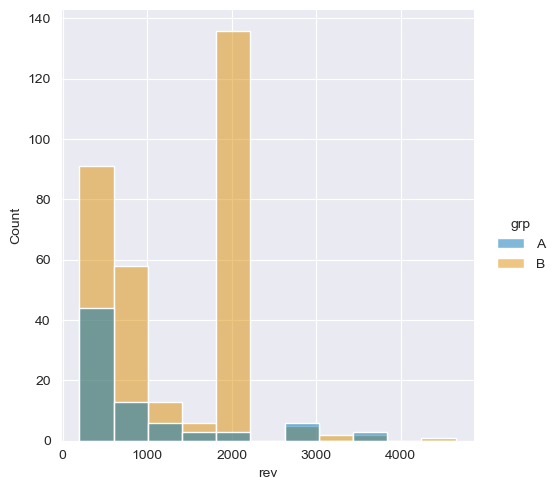

In [106]:
# Посмотрим на распределения значений выручки по группам среди активных пользователей
sns.displot(data=df_ab.query('paying==1 and active==1'), x='rev', hue='grp')

#### Как видим распределения далеки от нормальных, и значит сравнение средних с помощью Т-теста Стьюдента может дать не точный результат.
#### Поэтому для сравнения средней выручки лучше использовать бутстрап. Данный метод можно использовать при распределениях отличных от нормальных, а так же он не чувствителен к выбросам, как t-test.

In [91]:
# t-test
stats.ttest_ind(df_ab.query('paying==1 and active==1 and grp=="A"').rev,
                df_ab.query('paying==1 and active==1 and grp=="B"').rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

#### Т-тест показал статзначимые различия в тестовой и контрольной группах(p-value<0,05). Теперь проверим с помощью бутстрапа:

In [92]:
# bootstrap
# рассчитываем доверительный интервал для контрольной группы
bootstrap((df_ab.query('paying==1 and active==1 and grp=="A"').rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=756.3517699157742, high=1165.4934931117234), standard_error=103.54657803265314)

In [93]:
# bootstrap
# доверительный интервал для тестовой группы
bootstrap((df_ab.query('paying==1 and active==1 and grp=="B"').rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1170.6850569183416, high=1345.5297690498242), standard_error=44.41210358425952)

#### Доверительные интервалы в тестовой и контрольной группе не пересекаются, значит мы можем сделать вывод, что различия в средней выручке на платящего пользователя являются статистически значимыми.

### Выводы:
#### 1. По результатам эксперимента конверсия пользователей зашедших на платформу была ниже в тестовой группе, но стат-тест не выявил статистически значимых различий, и значит пока мы не можем утверждать, что новая механика оплаты как то повлияла на конверсию.
#### 2. Мы зафиксировали, что средняя выручка на платящего пользователя(ARPPU) выше в тестовой группе, чем в контрольной. Проведенные тесты, также подтвердили, что есть статистически значимые различия по данной метрике в разных группах. Но у нас недостаточно данных, чтобы понять за счет чего точно увеличилась средняя выручка(повышение среднего чека или увеличение количества повторных покупок пользователей). 
#### 3. На графике мы зафиксировали, что в группе B большинство чеков(или суммарная выручка с пользователя) равняется 1900, чего нет в группе А, возможно новая механика оплаты включала в себя какую то акцию(например 2 курса по цене 1900 или что то подобное), либо это технический момент, например различные А/В-тесты наложились друг на друга или система сплитования пользователей сработала некорректно. Однозначно ответить на этот вопрос мы не можем, нужны дополнительные данные и анализ.
### Рекомендации:
* **Не запускать новую механику оплаты на всех пользователей**
* **Углубиться в данные и разобраться, с чем связано аномальное количество чеков на 1900 в тестовой группе**

# 2. SQL-запросы

## 2.1 Очень усердные ученики.

#### Дана таблица default.peas
#### Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [105]:
# Создаем словарь с нужными параметрами для подключения к базе данных(данные для подключения скрыты)
connection_default = {'host': 'https://clickhouse.******',
                      'database': '******',
                      'user': '******', 
                      'password': '*******'
                     }

In [95]:
# создаем SQL-запрос
q = """WITH
    (SELECT MAX(toStartOfMonth(timest)) FROM peas) AS current_month --текущий месяц

SELECT
    COUNT(*) AS diligent_students
FROM
    (
    SELECT
        st_id,
        toStartOfMonth(timest) AS months,
        COUNT(correct) AS correct_decisions
    FROM peas
    WHERE
        correct == 1
    GROUP BY
        st_id,
        months
    HAVING
        correct_decisions >= 20
        AND months == current_month
    )"""

In [96]:
# Отправляем запрос и выводим результат
diligent_students = ph.read_clickhouse(query=q, connection=connection_default)
diligent_students

,diligent_students
0,136


## 2.2 Оптимизация воронки
### Условие
#### Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### Задача

#### Дана таблицы: default.peas, default.studs и default.final_project_check	
#### Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
* **ARPU** 
* **ARPAU** 
* **CR в покупку** 
* **СR активного пользователя в покупку** 
* **CR пользователя из активности по математике в покупку курса по математике**

#### ARPU считается относительно всех пользователей, попавших в группы.
#### Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
#### Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [97]:
# Создаем SQL-запрос
q="""SELECT
    s.test_grp AS test_grp,
    ROUND(SUM(f.money)/COUNT(DISTINCT toUInt64OrNull(s.st_id)), 2) AS ARPU,
    ROUND(SUM(f.money)/COUNT(DISTINCT toUInt64OrNull(a.st_id)), 2) AS ARPAU,
    ROUND(COUNT(DISTINCT toUInt64OrNull(f.st_id))/COUNT(DISTINCT toUInt64OrNull(s.st_id)), 2) AS CR,
    ROUND(COUNT(DISTINCT toUInt64OrNull(ap.st_id))/COUNT(DISTINCT toUInt64OrNull(a.st_id)), 2) AS CR_activ,
    ROUND(COUNT(DISTINCT toUInt64OrNull(amp.st_id))/COUNT(DISTINCT toUInt64OrNull(am.st_id)), 2) AS CR_activ_math
FROM studs AS s
LEFT JOIN final_project_check AS f --пользователи совершившие покупку
ON s.st_id = f.st_id

LEFT JOIN (
    SELECT
        st_id,
        COUNT(correct) AS correct_decisions
    FROM peas
    WHERE correct == 1
    GROUP BY st_id
    HAVING correct_decisions > 10
    ) AS a --активные пользователи
ON s.st_id = a.st_id

LEFT JOIN (
    SELECT
        st_id
    FROM (
        SELECT
            st_id,
            COUNT(correct) AS correct_decisions
        FROM peas
        WHERE correct == 1
        GROUP BY st_id
        HAVING correct_decisions > 10
        ) AS a
    JOIN (
        SELECT
            st_id,
            SUM(money) AS sum_money
        FROM final_project_check
        GROUP BY st_id
        ) AS fm
    ON a.st_id = fm.st_id
        ) AS ap --активные пользователи, совершившие покупку
ON s.st_id = ap.st_id

LEFT JOIN (
    SELECT
        st_id,
        COUNT(correct) AS correct_decisions_math
    FROM peas
    WHERE correct == 1
    AND subject == 'Math'
    GROUP BY st_id
    HAVING correct_decisions_math >= 2
    ) AS am --активные пользователи по математике
ON s.st_id = am.st_id

LEFT JOIN (
    SELECT
        st_id
    FROM (
        SELECT
            st_id,
            COUNT(correct) AS correct_decisions_math
        FROM peas
        WHERE correct == 1
        AND subject == 'Math'
        GROUP BY st_id
        HAVING correct_decisions_math >= 2
        ) AS am
    JOIN (
        SELECT
            st_id,
            SUM(money) AS sum_money
        FROM final_project_check
        WHERE subject == 'Math'
        GROUP BY st_id
        ) AS pm
    ON am.st_id = pm.st_id
    ) AS amp --активные пользователи по математике, купившие курс по математике
ON s.st_id = amp.st_id

GROUP BY s.test_grp"""

In [98]:
# Отправляем запрос и записываем результат в датафрейм
metrics_sql = ph.read_clickhouse(query=q, connection=connection_default)
metrics_sql

,test_grp,ARPU,ARPAU,CR,CR_activ,CR_activ_math
0,control,4540.98,10905.51,0.05,0.11,0.06
1,pilot,11508.47,35364.58,0.11,0.26,0.10


# Задание 3. Реализация функций на Python

#### 3.1 Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики из предыдущего задания.
#### 3.2 Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [99]:
# Функция принимает на вход словарь с параметрами подключения к базе данных и путь к файлу с дополнительными данными
# Возвращает датафрейм с пересчитанными метриками из предыдущего задания

def groups_add(connection_default, path):
    # Создаем SQL-запросы и считываем данные из базы данных
    q_studs = """SELECT * FROM studs"""
    q_peas = """SELECT st_id, correct, subject FROM peas"""
    q_final_project_check = """SELECT st_id, money, subject FROM final_project_check"""
    studs = ph.read_clickhouse(query=q_studs, connection=connection_default)
    peas = ph.read_clickhouse(query=q_peas, connection=connection_default)
    final_project_check = ph.read_clickhouse(query=q_final_project_check, connection=connection_default)

    # Считываем данные из дополнительного файла без заголовков, задаем названия столбцов как в базе данных 
    groups_add = pd.read_csv(path, skiprows=1, header=None, names=['st_id', 'test_grp'])

    # Меняем метки групп как в базе данных
    groups_add['test_grp'] = groups_add.test_grp.apply(lambda x: x.replace('A', 'control').replace('B', 'pilot'))

    # Объединяем данные из базы данных и дополнительного файла
    studs_new = pd.concat([studs, groups_add], axis=0, ignore_index=True)

    # Активные пользователи
    active_users = peas.query('correct == 1') \
        .groupby('st_id', as_index=False) \
        .agg({'correct': 'count'}) \
        .query('correct > 10')
    
    # Количество активных пользователей по группам
    active_users_grp = studs_new.merge(active_users) \
        .groupby('test_grp') \
        .agg({'st_id': 'nunique'}) \
        .rename(columns={'st_id': 'active_users'})

    # Пользователи совершившие покупку
    paying_users = final_project_check \
        .groupby('st_id', as_index=False) \
        .agg({'money': 'sum'})
    
    # Количество пользователей совершивших покупку по группам
    paying_users_grp = paying_users.merge(studs_new) \
        .groupby('test_grp') \
        .agg({'st_id': 'nunique'}) \
        .rename(columns={'st_id': 'paying_users'})

    # Активные пользователи совершившие покупку
    active_paying_users = active_users.merge(paying_users)
    
    # Количество активных пользователей совершивших покупку по группам
    active_paying_users_grp = active_paying_users.merge(studs_new) \
        .groupby('test_grp') \
        .agg({'st_id': 'count'}) \
        .rename(columns={'st_id': 'active_paying_users'})

    # Активные пользователи по математике
    active_users_math = peas.query('correct == 1 and subject == "Math"') \
        .groupby('st_id', as_index=False) \
        .agg({'correct': 'count'}) \
        .query('correct >= 2')
    
    # Количество активных пользователей по математике по группам
    active_users_math_grp = active_users_math.merge(studs_new) \
        .groupby('test_grp') \
        .agg({'st_id': 'count'}) \
        .rename(columns={'st_id': 'active_users_math'})

    # Активные пользователи по математике, купившие курс по математике
    active_paying_users_math = final_project_check.query('subject == "Math"') \
        .merge(active_users_math)
    
    # Количество активных пользователей по математике, купивших курс по математике, по группам
    active_paying_users_math_grp = active_paying_users_math.merge(studs_new) \
        .groupby('test_grp') \
        .agg({'st_id': 'count'}) \
        .rename(columns={'st_id': 'active_paying_users_math'})
  
    # Создаем датафрейм, в котором будем считать метрики. Считаем выручку и количество пользователей по группам
    metrics = studs_new.merge(final_project_check, how='left') \
        .groupby('test_grp') \
        .agg({'money': 'sum', 'st_id': 'nunique'}) \
        .rename(columns={'money': 'revenue', 'st_id': 'users'})
    
    # Объединяем все посчитанные показатели по группам
    metrics = pd.concat([metrics,
                        active_users_grp,
                        paying_users_grp,
                        active_paying_users_grp,
                        active_users_math_grp,
                        active_paying_users_math_grp], axis=1)
    # Считаем метрики
    metrics['ARPU'] = round(metrics.revenue / metrics.users, 2)  
    metrics['ARPAU'] = round(metrics.revenue / metrics.active_users, 2)
    metrics['CR'] = round(metrics.paying_users / metrics.users, 2)  
    metrics['CR_active'] = round(metrics.active_paying_users / metrics.active_users, 2)    
    metrics['CR_active_math'] = round(metrics.active_paying_users_math / metrics.active_users_math, 2)
    
    return metrics.reset_index()[['test_grp', 'ARPU', 'ARPAU', 'CR', 'CR_active', 'CR_active_math']]

In [100]:
# Функция принимает на вход датафрейм с метриками и строит по ним графики

def metric_charts(df):
    # Преобразовываем столбцы в строки
    df_melt = df.melt(id_vars='test_grp')
    
    # Для одновременного отображения двух графиков используем subplots()
    f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[3, 4]))
    
    # Задаем визуальное оформление графиков
    sns.set_style('darkgrid')
    sns.set_palette('colorblind')
    
    # График с метриками конверсий
    sns.barplot(data=df_melt.query('variable == "CR" or variable == "CR_active" or variable == "CR_active_math"'),
                x='variable',
                y='value',
                hue='test_grp',
                ax=axs[1])
    
    # График с метриками средней выручки
    sns.barplot(data=df_melt.query('variable == "ARPU" or variable == "ARPAU"'),
                x='variable',
                y='value',
                hue='test_grp',
                ax=axs[0])
    
    # Задаем названия графикам и осям
    f.suptitle('Metrics')
    axs[0].set_title('Average revenue')
    axs[1].set_title('Conversion')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('')
    plt.show()

#### Проверим работу функций

In [101]:
# Параметры подключения к базе данных
connection_default = {'host': 'https://clickhouse.******',
                      'database': '******',
                      'user': '******', 
                      'password': '******'
                     }
# Путь к файлу с дополнительными данными
path = 'groups_add.csv'

In [102]:
df_metrics = groups_add(connection_default, path)
df_metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4235.47,10905.51,0.05,0.11,0.06
1,pilot,9301.37,35364.58,0.09,0.26,0.10


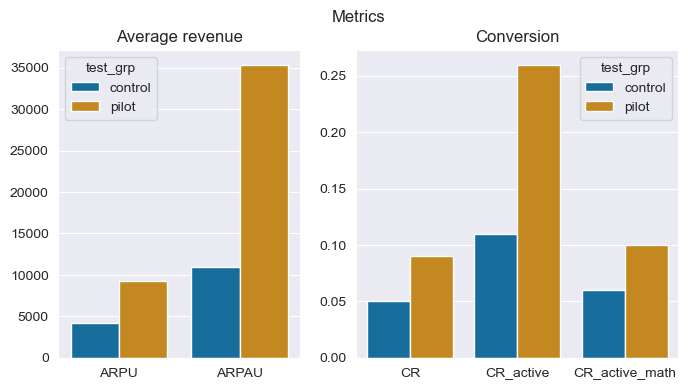

In [104]:
metric_charts(df_metrics)